### Overview of the Dataset
The dataset contains individual statistics for all first generation Pokemon. It includes attributes such as attack, defense, hit points (HP), and speed. All of these are measures related to their ability in battle.

The dataset includes 800 observations across 13 columns.

https://www.kaggle.com/shikhar1/pokemon/data

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
%matplotlib inline

### Read data in, take a look at the data, then determine if there are any missing values

In [101]:
pokemon = pd.read_csv('Pokemon.csv')

In [102]:
pokemon.shape

(800, 13)

In [103]:
#Drop Type 2 column, won't be needed for this exercise.

pokemon.drop(columns=['Type 2'], inplace=True)

In [104]:
pokemon.head(5)

,#,Name,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,309,39,52,43,60,50,65,1,False


In [105]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [106]:
#Create variable to find missing values across all columns

missing_values_count = pokemon.isnull().sum()
print(missing_values_count)

#             0
Name          0
Type 1        0
Total         0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64


In [107]:
#Create a separate sliced dataframe
pokemon_revised = pokemon.iloc[:, 3:10]

In [125]:
#Look at head of our independent variables
pokemon_revised.head(5)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,318,45,49,49,65,65,45
1,405,60,62,63,80,80,60
2,525,80,82,83,100,100,80
3,625,80,100,123,122,120,80
4,309,39,52,43,60,50,65


### Conduct Lasso Regression to see which features might be able to be omitted

In [128]:
from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pokemon_revised, pokemon['Legendary'], test_size=0.3)

In [140]:
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, y_train)

print('R² for our model:')
print(lass.score(X_train, y_train))

origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for our Model:')
print(origparams)

R² for our model:
0.2575674826381703

Parameter estimates for our Model:
[-9.91704572e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.10121249e-04 -0.00000000e+00 -0.00000000e+00  1.39703028e+00]


In [141]:
#Also test our model using the test data

print(lass.score(X_test, y_test))

0.2657745807692027


**Takeaway:** Based on the Lasso Regression above, we have discovered a couple things. First, there are only two features (Total and Special Attack) that were not equated to zero. Second, we learned that the regression performed a bit better on the actual test data. Let's use these two features to predict whether a pokemon is legendary or not.

### First we will build our Decision Tree Model

We will be attempting to predict whether or not a pokemon is legendary, based on the features of 'Total' and 'Sp. Atk'

In [144]:
#Create dataframe for our features
pokemon_features = pokemon_revised.loc[:,['Total','Sp. Atk']]

In [145]:
#Get dummies for Legendary column
pokemon['Legendary'] = pd.get_dummies(pokemon['Legendary'])

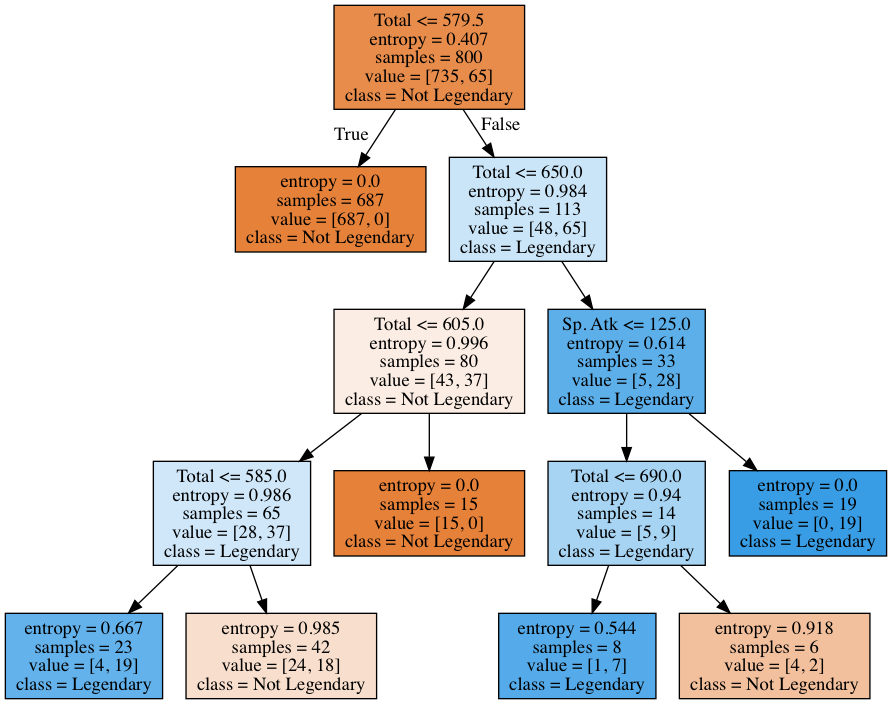

Program Executed in 0.22


In [169]:
#Initialize time
import timeit
start = timeit.default_timer()

# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=2,
    max_depth=4)

decision_tree.fit(pokemon_features, pokemon['Legendary'])

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names= pokemon_features.columns,
    class_names=['Not Legendary', 'Legendary'],
    filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))

#Print time
stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in {}".format(round(execution_time, 2)))

Validate Model - first by using cross validation, then by the train_test_split.

In [170]:
#Validate the model with cross-validation

print('Using Cross-Validation, our model produces the following accuracy for all data: ' + str(cross_val_score(decision_tree, pokemon_features, pokemon['Legendary'], cv=5)))

Using Cross-Validation, our model produces the following accuracy for all data: [0.96875 0.9625  0.95625 0.96875 0.95   ]


In [164]:
# Use train_test_split again to create the necessary training and test groups
X_train2, X_test2, y_train2, y_test2 = train_test_split(pokemon_features, pokemon['Legendary'], test_size=0.3)

In [172]:
#Validate model using train_test_split

print('Using Train_Test_Split, our model produces the following accuracy: ' + str(decision_tree.fit(X_train2, y_train2).score(X_test2, y_test2)))

Using Train_Test_Split, our model produces the following accuracy: 0.9666666666666667


### Now we will build our Random Forest Model and compare the runtimes

In [176]:
#Initialize time
import timeit
start = timeit.default_timer()

#Instantiate the model
rfc = ensemble.RandomForestClassifier()
X = pokemon_features
Y = pokemon['Legendary']

#Validate the model
print(cross_val_score(rfc, X, Y, cv=5))

#Print time
stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in {}".format(round(execution_time, 2)))

[0.96875 0.9625  0.9375  0.9625  0.925  ]
Program Executed in 0.12


**Conclusion:** Overall, found that the random forest classifier was 0.1 seconds faster than the decision tree classifier. This is most likely due to the fact that the dataset is not large or complex.